## FULL WORKING AdaBoost ANIMATION

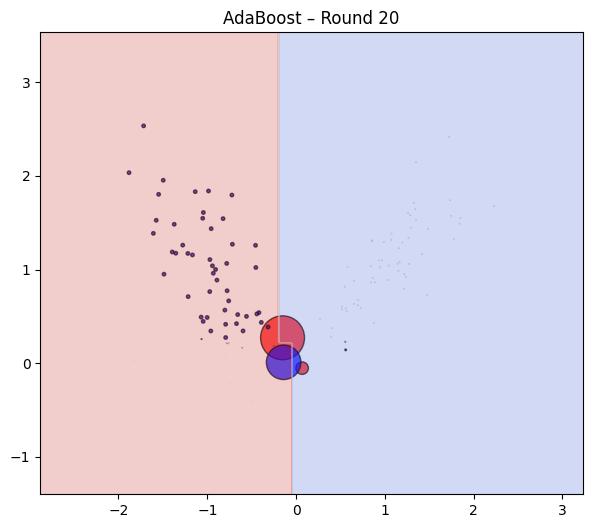

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification

# -----------------------------------------
# Output folder
# -----------------------------------------
os.makedirs("gifs", exist_ok=True)

# -----------------------------------------
# Dataset
# -----------------------------------------
X, y = make_classification(
    n_samples=120,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    random_state=3
)

y = np.where(y == 0, -1, 1)

# -----------------------------------------
# AdaBoost setup
# -----------------------------------------
T = 20  # boosting rounds
n = len(y)

weights = np.ones(n) / n
classifiers = []
alphas = []
weight_history = []

# -----------------------------------------
# Train AdaBoost manually
# -----------------------------------------
for t in range(T):
    clf = DecisionTreeClassifier(max_depth=1)
    clf.fit(X, y, sample_weight=weights)

    preds = clf.predict(X)
    miss = preds != y

    err = np.sum(weights[miss])
    err = max(err, 1e-10)

    alpha = 0.5 * np.log((1 - err) / err)

    # Update weights
    weights *= np.exp(-alpha * y * preds)
    weights /= np.sum(weights)

    classifiers.append(clf)
    alphas.append(alpha)
    weight_history.append(weights.copy())

# -----------------------------------------
# Visualization setup
# -----------------------------------------
fig, ax = plt.subplots(figsize=(7, 6))

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 250),
    np.linspace(y_min, y_max, 250)
)

writer = PillowWriter(fps=2)

# -----------------------------------------
# Animation
# -----------------------------------------
with writer.saving(fig, "gifs/adaboost_training.gif", dpi=120):
    for t in range(T):
        ax.clear()

        # Plot sample weights
        sizes = 1000 * weight_history[t] / weight_history[t].max()
        colors = ["red" if label == -1 else "blue" for label in y]

        ax.scatter(
            X[:, 0],
            X[:, 1],
            s=sizes,
            c=colors,
            alpha=0.7,
            edgecolor="k"
        )

        # Build ensemble decision surface
        Z = np.zeros(xx.shape)
        for i in range(t + 1):
            pred = classifiers[i].predict(
                np.c_[xx.ravel(), yy.ravel()]
            ).reshape(xx.shape)
            Z += alphas[i] * pred

        ax.contourf(
            xx, yy, np.sign(Z),
            alpha=0.25,
            cmap="coolwarm"
        )

        ax.set_title(f"AdaBoost – Round {t+1}")
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        writer.grab_frame()

plt.show()
